In [ ]:
# importa biblioteca pandas
import pandas as pd
# importa biblioteca numpy
import numpy as np
# importa biblioteca statsmodels
import statsmodels.api as sm

# local do arquivo
Caminho='/content/heart_failure_clinical_records_dataset (1).xlsx'


In [ ]:
 #Traz o arquivo para o Python
df=pd.read_excel(Caminho)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:

def stepwise_logistic_regression(X, y,
                                 initial_list=[],
                                 threshold_in=0.01,
                                 threshold_out=0.05,
                                 verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Adicionando variável: {} com p-value {:.6}'.format(best_feature, best_pval))

        # Backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Removendo variável: {} com p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

X = df.drop(columns=['DEATH_EVENT'])  # Variáveis preditoras - tira tipo que é a resposta e est_civ que virou dummy
y = df['DEATH_EVENT']  # Variável resposta

selected_features = stepwise_logistic_regression(X, y)

print('Variáveis selecionadas:')
print(selected_features)

Adicionando variável: time com p-value 5.99131e-15
Adicionando variável: ejection_fraction com p-value 1.05325e-05
Adicionando variável: serum_creatinine com p-value 3.30704e-05
Variáveis selecionadas:
['time', 'ejection_fraction', 'serum_creatinine']


In [ ]:
#Modelo de Regressão Logística pós Stepwise - somente as variáveis listadas acima
from statsmodels.formula.api import logit
modelo=logit('DEATH_EVENT ~ time + ejection_fraction + serum_creatinine', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.393669
         Iterations 7


In [ ]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            DEATH_EVENT   No. Observations:                  299
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.3728
Time:                        20:37:38   Log-Likelihood:                -117.71
converged:                       True   LL-Null:                       -187.67
Covariance Type:            nonrobust   LLR p-value:                 3.904e-30
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.0214      0.681      4.436      0.000       1.686       4.356
time                 -0.0212      0.003     -7.460      0.000      -0.027      -0.016
ejection_fraction    -0.0671      0.015     -4.512      0.000      -0.096      -0.038
serum_creatinine      0.7479      0.180      4.151      0.000       0.395       1.101
=====================================================================================
"""

In [ ]:
#Importa ferramentas para análise do modelo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


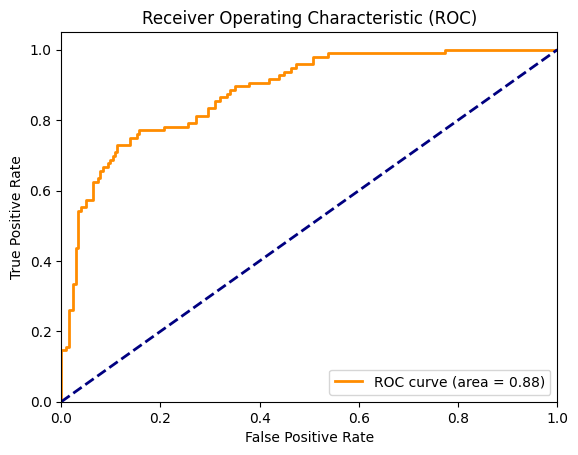

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.tools import add_constant

# Adicione uma constante ao DataFrame X
X_constant = add_constant(X[selected_features])

# Calcula as probabilidades previstas
y_pred_prob = modelo.predict(X_constant)

# Calcula o FPR (Taxa de Falsos Positivos) e TPR (Taxa de Verdadeiros Positivos)
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calcula a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from scipy.stats import chi2

# Calcula a estatística do teste de Hosmer-Lemeshow
hosmer_lemeshow_statistic = np.sum((y_pred_prob - y_pred_prob.mean())**2)

# Define o número de grupos (bins) para o teste de Hosmer-Lemeshow
num_groups = 10

# Calcula os graus de liberdade
df = num_groups - 2

# Calcula o valor-p comparando a estatística do teste com a distribuição qui-quadrado
p_value = 1 - chi2.cdf(hosmer_lemeshow_statistic, df)

# Exibe o valor-p com três casas decimais
print("Valor-p do teste de Hosmer-Lemeshow: {:.3f}".format(p_value))

Valor-p do teste de Hosmer-Lemeshow: 0.001


In [ ]:
# Matriz de Confusão
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[184  19]
 [ 32  64]]


In [ ]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(y, y_pred)

# Calcula o total de observações
total_observations = np.sum(conf_matrix)

# Calcula o total de acertos (soma da diagonal principal)
total_acertos = np.trace(conf_matrix)

# Calcula o total de erros (subtrai o total de acertos do total de observações)
total_erros = total_observations - total_acertos

# Calcula a porcentagem de acertos e erros
percent_acertos = (total_acertos / total_observations) * 100
percent_erros = (total_erros / total_observations) * 100

# Exibe os resultados
print("Total de acertos:", total_acertos)
print("Total de erros:", total_erros)
print("Porcentagem de acertos: {:.2f}%".format(percent_acertos))
print("Porcentagem de erros: {:.2f}%".format(percent_erros))

Total de acertos: 248
Total de erros: 51
Porcentagem de acertos: 82.94%
Porcentagem de erros: 17.06%


In [ ]:
import numpy as np

L0 = np.exp(-187.67)
LM = np.exp(-117.71)
L0, LM

R2_CS = 1 - (L0 / LM) ** (2 / 299)
R2_CS

# Exibe a estatística de Cox e Snell
print("Estatística de Cox e Snell:", R2_CS)

Estatística de Cox e Snell: 0.3737213419173957


In [ ]:
#Confirmar precisão

import numpy as np

# Valores de Log-Verossimilhança do modelo ajustado e modelo nulo do resumo do modelo
LL_null = -187.67  # Log-verossimilhança do modelo nulo
LL_model = -117.71  # Log-verossimilhança do modelo ajustado
n = 299  # Número de observações

# Converter log-verossimilhanças para verossimilhanças
L0 = np.exp(LL_null)
LM = np.exp(LL_model)

# Calcular a estatística de Cox e Snell
R2_CS = 1 - (L0 / LM) ** (2 / n)
R2_CS

0.3737213419173957

In [ ]:
import numpy as np

# Valores de Log-Verossimilhança do modelo ajustado e modelo nulo do resumo do modelo
LL_null = -187.67  # Log-verossimilhança do modelo nulo
LL_model = -117.71  # Log-verossimilhança do modelo ajustado
n = 299  # Número de observações

# Converter log-verossimilhanças para verossimilhanças
L0 = np.exp(LL_null)
LM = np.exp(LL_model)

# Calcular a estatística de Cox e Snell
R2_CS = 1 - (L0 / LM) ** (2 / n)

# Calcular a estatística de Nagelkerke
R2_N = R2_CS / (1 - L0 ** (2 / n))
R2_N
print("Estatística de Nagelkerke:", R2_N)

Estatística de Nagelkerke: 0.5226764358159977


In [ ]:
# Calcula a função de verossimilhança do modelo nulo (sem preditores)
llf_null = modelo.llnull

# Calcula a função de verossimilhança do modelo ajustado
llf_modelo = modelo.llf

# Calcula o número total de observações
n = len(y)

# Calcula a estatística de Nagelkerke
R2_nagelkerke = 1 - (np.exp(-2 * (llf_null - llf_modelo) / n) / (1 - np.exp(llf_modelo * 2 / n)))

# Exibe a estatística de Nagelkerke
print("Estatística de Nagelkerke:", R2_nagelkerke)

Estatística de Nagelkerke: -1.9302221484768078
